# RBC Model With The Allowance of Differing Rates of Capital Utilization

Typically, the RBC model does not allow for differing rates of capital strain, as this is left fixed. However, in this project, I will analyze the difference between the impulse responses from a shock to TFP when capital strain is allowed to vary. For example, imagine an Uber driver would be able to strain his car further by driving more hours in a day after TFP is shocked, as opposed to assuming this is fixed. Another example would be a factory straining its machinery more, which will lead to more output.

However, a byproduct of this increased strain is an increase in wear and tear, which will also cost money. Thus, this project provides an interest insight as to how the economy would react to the ability to change the amount of strain on capital, as the optimal solution will not necessarily be to just simply strain capital as much as possible, because this will lead to higher costs in the form of needing to replace the capital which costs money.

Thus, the goal of this project is to analyze the RBC model's forecasts of how the economy would react to a shock to total factor productivity when agents are able to strain their capital more or less. We will compare this to the model where capital utilization is simply fixed, and look at how they differ.

In [130]:
#Install linearsolve package for future computation of linear approximations of steady state conditions 
!pip install linearsolve

In [131]:
#install numpy for array operations
import numpy as np

#install pandas for data management
import pandas as pd

#import linearsolve for steady state computation
import linearsolve as ls

#import matplotlib for graphing
import matplotlib.pyplot as plt

#change the background used for visual effect
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

## RBC Model

In [133]:
#data from FRED
url = "https://raw.githubusercontent.com/sahilh99/Sahil-Habibi-Econ-Research-Code/refs/heads/Macroeconomics-Code/RBC%20Models/RBC%20Model%20With%20Variable%20Capital%20Utilization/TCU.csv"

#create dataframe using the csv
df = pd.read_csv(url,index_col=0,parse_dates=True)

#print sample, TCU = Total Capacity Utilization
df.head()


,TCU
DATE,
1967-01-01,89.3902
1967-02-01,87.9750
1967-03-01,87.0835
1967-04-01,87.5089
1967-05-01,86.3566


TCU    80.058011
dtype: float64

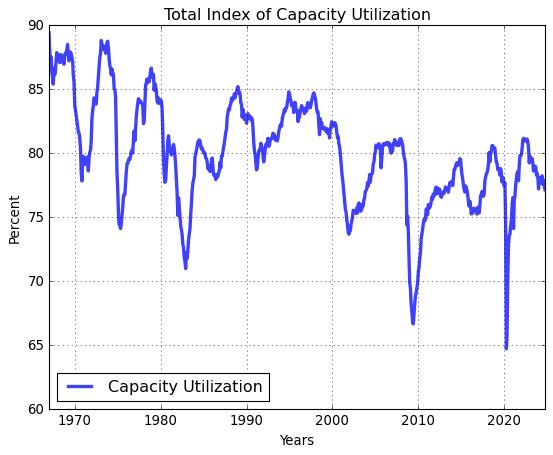

In [134]:
#Visualize Total Capacity Utilization over time

#Create figure and then plot on the figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df, lw=3, alpha=0.75, label="Capacity Utilization")

#Create title for graph and labels for axes
ax.set_ylabel('Percent')
ax.set_xlabel('Years')
ax.set_title('Total Index of Capacity Utilization')
#Adding Legend
ax.legend(loc='lower left');

#Add grid to graph
ax.grid()

#Save the figure as PNG and reduce white space around figure
#fig.savefig('ic.png',dpi=120,bbox_inches='tight')

#print average total capital utilization
df.mean()

In [135]:
#create dictionary for parameters for our model
parameters = pd.Series({
    'beta': 0.9900,
    'phi': 1.7317,
    'alpha': 0.3500,
    'delta0': 0.0342,
    'gamma': 1.4040,
    'rho': 0.7500
}, dtype=float)

#Create list of exogenous state variables, variables depending on past values and outside of model
exo_states = ['a']  # TFP (solow residual)

#Create list of endogenous state variables, variables depending on past values but garnered from the model
endo_states = ['k']  # Capital 

#Create list of costate variables, variables depending on future values
costates = ['c', 'l', 'u', 'y', 'i']  


We are going to find our solutions to the equilibrium conditions which result from the following equations:

Lifetime consumption maximization problem for household:

$$
\max_{C_t, L_t, u_t, K_{t+1}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t \left[ \log(C_t) + \varphi \log(1 - L_t) \right]
$$

Subject to:

$$
C_t + K_{t+1} = A_t \left( u_t K_t \right)^{\alpha} L_t^{1 - \alpha} + \left(1 - \delta_0 u_t^{\gamma}\right) K_t
$$

Capital evolution:
$$
K_{t+1} = I_t + (1 - \delta_0 u_t^{\gamma}) K_t 
$$

Cobb-Douglas Production Function:
$$
Y_t = A_t (u_t K_t)^{\alpha} L_t^{1 - \alpha}
$$

TFP evolution equation:
$$
A_{t+1} = \rho A_t + \epsilon_t
$$


In our equations, the $u_{t}$ term represents our capital utilization factor. Typically, this variable is not present. 
Thus, this variable will allow us to be able to measure the difference in our model's equilibrium conditions upon the inclusion of this variable. Our $\gamma$ parameter will be the significance measure of how much is being used.

In [138]:
def equations(variables_forward,variables_current,parameters):
    
    p = parameters
    cur = variables_current    
    fwd = variables_forward
    
    #Production Function
    production_function = cur.a * (cur.u * cur.k)**p.alpha * cur.l**(1-p.alpha) - cur.y

    #FOC ut
    # labor_leisure = 1-p.alpha/((1-p.alpha)-p.phi)
    capital_utilization = (p.alpha*cur.y)/(cur.u) - p.gamma*p.delta0*cur.u**(p.gamma-1)*cur.k

    # capital utilization equation: fixed u
    # capital_utilization = 0.8000249188315649 - cur.u 
    
    #FOC Lt
    utilization_labor = (1-p.alpha)*cur.y/cur.l/cur.c - p.phi/(1-cur.l)
    
    #FOC K(t+1)
    euler_equation = 1/cur.c - p.beta*(p.alpha*fwd.y /fwd.k + 1 - p.delta0*fwd.u**p.gamma) / fwd.c

    #Capital Evolution
    capital_evolution = cur.i + (1 - p.delta0*cur.u**p.gamma)*cur.k - fwd.k

    #TFP Evolution
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)

    #Budget Constraint 
    market_clearing = cur.c+cur.i - cur.y

    #Stack equilibrium conditions into a numpy array
    return np.array([
        production_function,
        capital_utilization,
        utilization_labor,
        euler_equation,
        capital_evolution,
        tfp_process,
        market_clearing
        ])

In [139]:
#Define the fixed utilization RBC model
rbc_model_fixed = ls.model(
    equations=equations_fixed,
    exo_states=exo_states,
    endo_states=endo_states,
    costates=costates,
    parameters=parameters
)

#Initial guess for steady state
guess = pd.Series({'a': 1, 'k': 4, 'y': 1, 'c': 1, 'l': 0.5, 'u': 0.5, 'i': 1})

#Compute and store steady-state values
rbc_model_fixed.compute_ss(guess)
steady_state = rbc_model_fixed.ss

#Print results
print("Steady State Values:\n", steady_state.to_string())


Steady State Values:
 a     1.000000
k    10.166941
c     0.765502
l     0.333332
u     0.800025
y     1.019701
i     0.254199


In [140]:
def equations_fixed(variables_forward,variables_current,parameters):
    
    p = parameters
    cur = variables_current    
    fwd = variables_forward
    
    #Production Function
    production_function = cur.a * (cur.u * cur.k)**p.alpha * cur.l**(1-p.alpha) - cur.y

    #FOC ut
    #Labor_leisure = 1-p.alpha/((1-p.alpha)-p.phi)
    #Capital_utilization = (p.alpha*cur.y)/(cur.u) - p.gamma*p.delta0*cur.u**(p.gamma-1)*cur.k

    #Capital utilization equation: fixed u
    capital_utilization = 0.8000249188315649 - cur.u 
    
    #FOC Lt
    utilization_labor = (1-p.alpha)*cur.y/cur.l/cur.c - p.phi/(1-cur.l)
    
    #FOC K(t+1)
    euler_equation = 1/cur.c - p.beta*(p.alpha*fwd.y /fwd.k + 1 - p.delta0*fwd.u**p.gamma) / fwd.c

    #Capital Evolution
    capital_evolution = cur.i + (1 - p.delta0*cur.u**p.gamma)*cur.k - fwd.k

    #TFP Evolution
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)

    #Budget Constraint 
    market_clearing = cur.c+cur.i - cur.y

    #Stack equilibrium conditions into a numpy array
    return np.array([
        production_function,
        capital_utilization,
        utilization_labor,
        euler_equation,
        capital_evolution,
        tfp_process,
        market_clearing
        ])

In [141]:
#Create our RBC model with fixed capital utilization
rbc_model_fixed = ls.model(
    equations=equations_fixed,
    exo_states=exo_states,
    endo_states=endo_states,
    costates = costates,
    parameters=parameters
)

#Compute our guess for the steady state solutions for each variable
guess = pd.Series({
   'a':1,
   'k':4,
   'y':1,
   'c':1,
   'l':0.5,
   'u':0.5,
   'i':1
   })

#Compute steady state result 
rbc_model_fixed.compute_ss(guess)
steady_state = rbc_model_fixed.ss
print("Steady State Values:")
print(steady_state)

Steady State Values:
a     1.000000
k    10.166941
c     0.765502
l     0.333332
u     0.800025
y     1.019701
i     0.254199
dtype: float64


In [142]:
#Store our two models in a dictionary
models = {
    "variable_utilization": rbc_model,
    "fixed_utilization": rbc_model_fixed
}

#Approximate, solve, and compute impulse responses
irs_results = {}

for name, model in models.items():
    model.approximate_and_solve()
    model.impulse(T=41, t0=5, shocks=[0.01])
    irs_results[name] = model.irs  # Store results in dictionary

#Access results as irs_results['variable_utilization'] or irs_results['fixed_utilization']

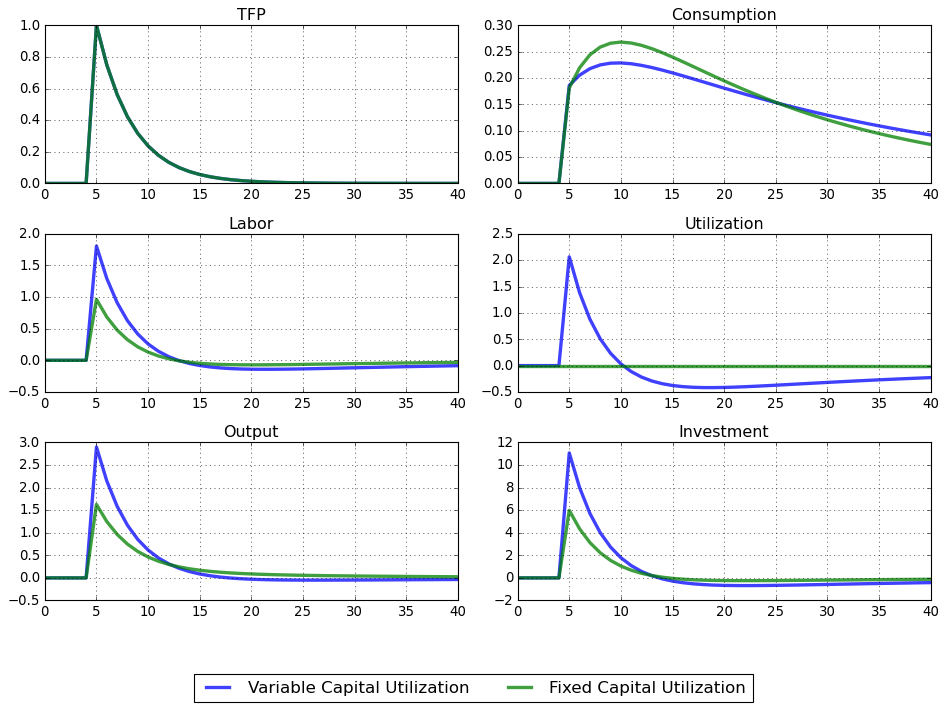

In [143]:
#Create figure and axes to plot all of our impulse responses on
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

#Variable labels
titles = ['TFP', 'Consumption', 'Labor', 'Utilization', 'Output', 'Investment']
vars_to_plot = ['a', 'c', 'l', 'u', 'y', 'i']

#Loop through subplots
for ax, var, title in zip(axes.flatten(), vars_to_plot, titles):
    ax.plot(rbc_model.irs['e_a'][var] * 100, lw=3, alpha=0.75, label='Variable Capital Utilization')
    ax.plot(rbc_model_fixed.irs['e_a'][var] * 100, lw=3, alpha=0.75, label='Fixed Capital Utilization')
    ax.set_title(title)
    ax.grid()

#Add a legend to differentiate between fixed capacity utilization and variable capacity utilization
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=15)

plt.tight_layout()
plt.show()


# Results, Analysis, And Conclusions

We make some interesting findings, notably that the initial shock to consumption is actually stronger in the model where capital utilization is fixed compared to when it is variable. This is because there's more incentive to boost investment as compared to consumption due to a higher marginal product of capital resulting from the increase in gamma. This leads to a harder push towards investment in the variable model compared to the fixed model.

We also see that the impulse response to labor is a lot stronger in the variable capital utilization model compared to the fixed one. This is because the increased strain on capital is requiring an increase in the amount of labor, which is spiking up the amount of labor in the economy, as it is more desirable to do so.

We note that the capital utilization spikes in response to the TFP shock, but then eventually actually goes below that of the original fixed model. This is likely because capital needs to be replaced, and once the TFP shock wears off, agents are trying to rebound their equipment in the post TFP-shock phase.

Output also has a much stronger response in the variable capital utilization model, because capital is being strained harder, leading to more output. Imagine a factory using its machinery more, leading to more output. Further, due to this increase in usage, there is an increase in labor that is complemented with it, and thus is further contributing to increased output. However, once the dust has settled, the shock to output is actually lower for the variable capital utilization model compared to the fixed one.

In the last graph, we see that investment has a much higher shock in the variable model. This is of course because the marginal product of capital has risen, and so investing in equipment is much more desireable for agents compared to the fixed model. 